In [1]:
import os
import sys
sys.path.append('/usr/src/code/src')
os.chdir('/usr/src/code/')

import torch

from torch.optim import Adam

from functools import partial
# Visualization tools
import matplotlib.pyplot as plt

from src.models.UNet import UNet, UNet2DWrapper
from src.utils.other_utils import *
from src.pdlmc.constraints import classifier_constraint, brightness_constraint
from src.utils.samplers import *
from src.utils.trainers import *
from src.utils.schedulers import *


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%matplotlib inline

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMG_SIZE = 28
IMG_CH = 1
BATCH_SIZE = 128
N_CLASSES = 10
data, dataloader = load_transformed_MNIST(IMG_SIZE, BATCH_SIZE)
ncols = 5
timesteps = 500
scheduler = CosineScheduler(timesteps=timesteps, device=device)

In [ ]:
model = UNet(
    timesteps, IMG_CH, IMG_SIZE, down_chs=(64, 64, 128), t_embed_dim=8, c_embed_dim=0
)
# model = UNet.UNet2DWrapper()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model.to(device)

trainer = DDPMTrainer(scheduler=scheduler, device=device, train_timesteps=scheduler.t, sample_timesteps=scheduler.t)
ddpm_sampler = DDPMSampler(
    scheduler=scheduler, device=device, img_ch=IMG_CH, img_size=IMG_SIZE,
)

In [ ]:
num_epochs = 4
losses, model = trainer.train(
    model=model,
    dataloader=dataloader,
    num_epochs=num_epochs,
    sampler=ddpm_sampler,
    plot=True,
)
torch.save(model, "model.pkl")

In [3]:
model = torch.load('model.pkl', weights_only=False)
classifier = torch.load('mnist_classifier.pkl',  weights_only=False)

	 Sampling images: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


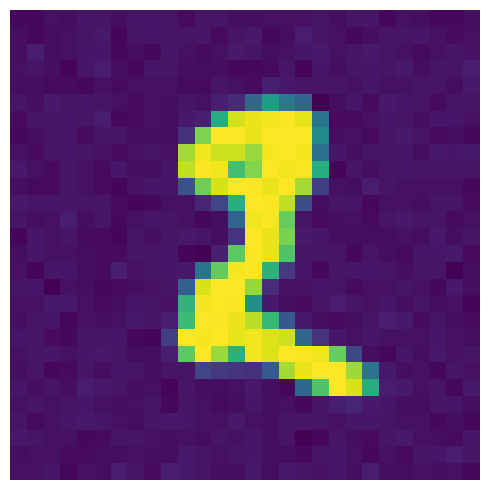

In [4]:
import numpy as np

vpsde_sampler = VPSDESampler(
    scheduler=scheduler, device=device, img_ch=IMG_CH, img_size=IMG_SIZE
)

img = sample_images(model=model, img_ch=IMG_CH, img_size=IMG_SIZE, reverse=vpsde_sampler.reverse, timesteps=scheduler.t, device=device, sample_size=1, plot=True, save=False)

# Generate 100 images
# imgs_vpsde = [vpsde_sampler.sample_images(model=model) for _ in range(100)]
# print(f"Generated {len(imgs_vpsde)} images using VPSDESampler.")
# calculate_class_proportions(imgs_vpsde, classifier, n_classes=N_CLASSES, device=device)

# gfuncs = [partial(classifier_constraint, classifier=classifier, target_class=9, epsilon=0.01)]
# lmc_steps: int = 1
# step_size: float = 1.8
# step_size_lambda: float = 0.4

# pdlmc_sampler = PDLMCSampler(
#     scheduler=scheduler,
#     device=device,
#     img_ch=IMG_CH,
#     img_size=IMG_SIZE,
#     ncols=ncols,
#     gfuncs=gfuncs,
#     lmc_steps=lmc_steps,
#     step_size=step_size,
#     step_size_lambda=step_size_lambda,
# )

# imgs_pdlmc = [pdlmc_sampler.sample_images(model=model) for _ in range(100)]
# print(f"Generated {len(imgs_pdlmc)} images using PDLMCSampler.")
# calculate_class_proportions(imgs_pdlmc, classifier, n_classes=N_CLASSES, device=device)
# img = torch.clamp(img, 0, 1)
# img = img.view(img.size(0), -1)
# mean_brightness = img.mean()

# print(f"Mean brightness of the generated image: {mean_brightness.item():.4f}")

In [ ]:
gfuncs = [partial(classifier_constraint, classifier=classifier, target_class=9, epsilon=0.01)]
lmc_steps: int = 1
step_size: float = 1.8
step_size_lambda: float = 0.4

pdlmc_sampler = PDLMCSampler(
    scheduler=scheduler,
    device=device,
    img_ch=IMG_CH,
    img_size=IMG_SIZE,
    ncols=ncols,
    gfuncs=gfuncs,
    lmc_steps=lmc_steps,
    step_size=step_size,
    step_size_lambda=step_size_lambda,
)

img = pdlmc_sampler.sample_images(model=model)
# img = torch.clamp(img, 0, 1)
# img = img.view(img.size(0), -1)
# mean_brightness = img.mean()

# print(f"Mean brightness of the generated image: {mean_brightness.item():.4f}")